In [1]:
import os

cache_dir ='/scratch/hakeem.at/Queryable-Shared-Reference-Repository/notebooks/pretrained_models'

os.environ['HF_HOME'] = cache_dir
os.environ['TRANSFORMERS_CACHE'] = cache_dir
os.environ['HUGGINGFACE_HUB_CACHE'] = cache_dir

In [18]:
import pandas as pd

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer

In [42]:
df = pd.read_json("prompt_thresholding_responses.jsonl")
df.head()

,question,question_type,context,source,ground_truth,prompt_type,raw_response
0,What is the DOI for the Supporting Information...,answerable,The Supporting Information is available free o...,Holzlechner et al. - 2017 - In Situ Characteri...,The Supporting Information is available free o...,baseline,10.1021/acs.jproteome.6b00610
1,How might the findings from these MALDI MS ima...,borderline,The Supporting Information is available free o...,Holzlechner et al. - 2017 - In Situ Characteri...,None,baseline,The findings from these MALDI MS images could ...
2,What software was used to process the MALDI MS...,unanswerable,The Supporting Information is available free o...,Holzlechner et al. - 2017 - In Situ Characteri...,None,baseline,The software used to process the MALDI MS imag...
3,What method was used to measure local variance...,answerable,Table /1 the derivative of the sum of local co...,Cachier and Pennec - 2000 - 3D non-rigid regis...,cal variance using the difference of mean rela...,baseline,The method used to measure local variance usin...
4,How might the use of a recursive implementatio...,borderline,Table /1 the derivative of the sum of local co...,Cachier and Pennec - 2000 - 3D non-rigid regis...,None,baseline,The use of a recursive implementation for the ...


In [43]:
QUESTION_TYPES = ['answerable','unanswerable','borderline']

In [44]:
df = df[df['question_type']!=QUESTION_TYPES[1]]
df.head()

,question,question_type,context,source,ground_truth,prompt_type,raw_response
0,What is the DOI for the Supporting Information...,answerable,The Supporting Information is available free o...,Holzlechner et al. - 2017 - In Situ Characteri...,The Supporting Information is available free o...,baseline,10.1021/acs.jproteome.6b00610
1,How might the findings from these MALDI MS ima...,borderline,The Supporting Information is available free o...,Holzlechner et al. - 2017 - In Situ Characteri...,None,baseline,The findings from these MALDI MS images could ...
3,What method was used to measure local variance...,answerable,Table /1 the derivative of the sum of local co...,Cachier and Pennec - 2000 - 3D non-rigid regis...,cal variance using the difference of mean rela...,baseline,The method used to measure local variance usin...
4,How might the use of a recursive implementatio...,borderline,Table /1 the derivative of the sum of local co...,Cachier and Pennec - 2000 - 3D non-rigid regis...,None,baseline,The use of a recursive implementation for the ...
6,What cell lines were obtained from American Ty...,answerable,For details about the chemicals used in the st...,Zhang et al. - 2023 - Single-cell lipidomics e...,"The commercial human cell lines, including pan...",baseline,The cell lines obtained from American Type Cul...


In [45]:
def create_ground_truth_label(row):
    if row.question_type=='answerable':
        return 1
    else:
        return 0
df['ground_truth_label'] = df.apply(lambda x: create_ground_truth_label(x), axis=1)
df.head()

,question,question_type,context,source,ground_truth,prompt_type,raw_response,ground_truth_label
0,What is the DOI for the Supporting Information...,answerable,The Supporting Information is available free o...,Holzlechner et al. - 2017 - In Situ Characteri...,The Supporting Information is available free o...,baseline,10.1021/acs.jproteome.6b00610,1
1,How might the findings from these MALDI MS ima...,borderline,The Supporting Information is available free o...,Holzlechner et al. - 2017 - In Situ Characteri...,None,baseline,The findings from these MALDI MS images could ...,0
3,What method was used to measure local variance...,answerable,Table /1 the derivative of the sum of local co...,Cachier and Pennec - 2000 - 3D non-rigid regis...,cal variance using the difference of mean rela...,baseline,The method used to measure local variance usin...,1
4,How might the use of a recursive implementatio...,borderline,Table /1 the derivative of the sum of local co...,Cachier and Pennec - 2000 - 3D non-rigid regis...,None,baseline,The use of a recursive implementation for the ...,0
6,What cell lines were obtained from American Ty...,answerable,For details about the chemicals used in the st...,Zhang et al. - 2023 - Single-cell lipidomics e...,"The commercial human cell lines, including pan...",baseline,The cell lines obtained from American Type Cul...,1


In [46]:
NON_ANSWER_TEMPLATES = {
    "absence": [
        "The information is not mentioned in the document.",
        "This detail is not provided in the text.",
        "The document does not specify this information.",
        "There is no mention of this in the available content.",
    ],
    
    "uncertainty": [
        "I cannot determine this from the given information.",
        "It is unclear based on the available context.",
        "I don't have enough information to answer.",
        "Unable to find this information in the provided text.",
    ],
    
    "insufficient_evidence": [
        "The context does not contain sufficient details to answer.",
        "Based on the provided documents, I cannot answer this.",
        "The retrieved information is insufficient to respond.",
        "There isn't enough information in the sources to determine this.",
    ],
    
    "explicit_limitation": [
        "The document does not address this question.",
        "This topic is not covered in the available material.",
        "The text doesn't include information about this.",
        "This falls outside the scope of the provided documents.",
    ],
    
    "apologetic": [
        "I apologize, but I cannot find this information.",
        "Unfortunately, the document doesn't mention this.",
        "I'm unable to provide an answer based on the available text.",
        "Sorry, but this information is not present in the context.",
    ],
}

templates = [template for category_templates in NON_ANSWER_TEMPLATES.values() for template in category_templates]

In [8]:
model = SentenceTransformer('all-MiniLM-L6-v2', device="cuda")

In [9]:
template_embeddings = model.encode(templates, show_progress_bar=False)

In [10]:
sim = cosine_similarity(template_embeddings, [template_embeddings[0]])
sim.max()

np.float32(1.0000002)

In [47]:
def similarity_eval(raw_response, threshold=0.65):
    response_embedding = model.encode([raw_response])
    similarity = cosine_similarity(template_embeddings, response_embedding)
    score = similarity.max()
    if score>=threshold:
        return 0
    return 1

def create_prediction_label(row):
    if row.raw_response:
        if "i don't know" in row.raw_response.lower():
            return 0
        else:
            return similarity_eval(row.raw_response.lower())
    else:
        return 0
        
df['prediction_label'] = df.apply(lambda x: create_prediction_label(x), axis=1)
df.head()

,question,question_type,context,source,ground_truth,prompt_type,raw_response,ground_truth_label,prediction_label
0,What is the DOI for the Supporting Information...,answerable,The Supporting Information is available free o...,Holzlechner et al. - 2017 - In Situ Characteri...,The Supporting Information is available free o...,baseline,10.1021/acs.jproteome.6b00610,1,1
1,How might the findings from these MALDI MS ima...,borderline,The Supporting Information is available free o...,Holzlechner et al. - 2017 - In Situ Characteri...,None,baseline,The findings from these MALDI MS images could ...,0,1
3,What method was used to measure local variance...,answerable,Table /1 the derivative of the sum of local co...,Cachier and Pennec - 2000 - 3D non-rigid regis...,cal variance using the difference of mean rela...,baseline,The method used to measure local variance usin...,1,1
4,How might the use of a recursive implementatio...,borderline,Table /1 the derivative of the sum of local co...,Cachier and Pennec - 2000 - 3D non-rigid regis...,None,baseline,The use of a recursive implementation for the ...,0,1
6,What cell lines were obtained from American Ty...,answerable,For details about the chemicals used in the st...,Zhang et al. - 2023 - Single-cell lipidomics e...,"The commercial human cell lines, including pan...",baseline,The cell lines obtained from American Type Cul...,1,1


In [48]:
PROMPT_TYPES = ['baseline','explicit_idk','confidence_threshold','confidence_rubric']

In [49]:
df_baseline = df[df['prompt_type']==PROMPT_TYPES[0]]
df_explicit_idk = df[df['prompt_type']==PROMPT_TYPES[1]]
df_confidence_threshold = df[df['prompt_type']==PROMPT_TYPES[2]]
df_confidence_rubric = df[df['prompt_type']==PROMPT_TYPES[3]]
df_confidence_rubric.head()

,question,question_type,context,source,ground_truth,prompt_type,raw_response,ground_truth_label,prediction_label
4500,What is the DOI for the Supporting Information...,answerable,The Supporting Information is available free o...,Holzlechner et al. - 2017 - In Situ Characteri...,The Supporting Information is available free o...,confidence_rubric,,1,0
4501,How might the findings from these MALDI MS ima...,borderline,The Supporting Information is available free o...,Holzlechner et al. - 2017 - In Situ Characteri...,None,confidence_rubric,I don't know.,0,0
4503,What method was used to measure local variance...,answerable,Table /1 the derivative of the sum of local co...,Cachier and Pennec - 2000 - 3D non-rigid regis...,cal variance using the difference of mean rela...,confidence_rubric,,1,0
4504,How might the use of a recursive implementatio...,borderline,Table /1 the derivative of the sum of local co...,Cachier and Pennec - 2000 - 3D non-rigid regis...,None,confidence_rubric,,0,0
4506,What cell lines were obtained from American Ty...,answerable,For details about the chemicals used in the st...,Zhang et al. - 2023 - Single-cell lipidomics e...,"The commercial human cell lines, including pan...",confidence_rubric,,1,0


## Answerable Vs Unanswerable

### Baseline

In [37]:
ground_truth = df_baseline['ground_truth_label']
predictions = df_baseline['prediction_label']

accuracy = accuracy_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions, zero_division=0)
recall = recall_score(ground_truth, predictions, zero_division=0)
f1 = f1_score(ground_truth, predictions, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.5020
Precision: 0.5010
Recall:    0.9940
F1 Score:  0.6662


### Explicit I Don't Know

In [38]:
ground_truth = df_explicit_idk['ground_truth_label']
predictions = df_explicit_idk['prediction_label']

accuracy = accuracy_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions, zero_division=0)
recall = recall_score(ground_truth, predictions, zero_division=0)
f1 = f1_score(ground_truth, predictions, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.7500
Precision: 0.9960
Recall:    0.5020
F1 Score:  0.6676


### Confidence Threshold

In [39]:
ground_truth = df_confidence_threshold['ground_truth_label']
predictions = df_confidence_threshold['prediction_label']

accuracy = accuracy_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions, zero_division=0)
recall = recall_score(ground_truth, predictions, zero_division=0)
f1 = f1_score(ground_truth, predictions, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.5990
Precision: 1.0000
Recall:    0.1980
F1 Score:  0.3306


### Confidence Rubric

In [40]:
ground_truth = df_confidence_rubric['ground_truth_label']
predictions = df_confidence_rubric['prediction_label']

accuracy = accuracy_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions, zero_division=0)
recall = recall_score(ground_truth, predictions, zero_division=0)
f1 = f1_score(ground_truth, predictions, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.7200
Precision: 1.0000
Recall:    0.4400
F1 Score:  0.6111


## Answerable Vs Borderline

### Baseline

In [50]:
ground_truth = df_baseline['ground_truth_label']
predictions = df_baseline['prediction_label']

accuracy = accuracy_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions, zero_division=0)
recall = recall_score(ground_truth, predictions, zero_division=0)
f1 = f1_score(ground_truth, predictions, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.5070
Precision: 0.5035
Recall:    0.9940
F1 Score:  0.6685


### Explicit I Don't Know

In [51]:
ground_truth = df_explicit_idk['ground_truth_label']
predictions = df_explicit_idk['prediction_label']

accuracy = accuracy_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions, zero_division=0)
recall = recall_score(ground_truth, predictions, zero_division=0)
f1 = f1_score(ground_truth, predictions, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.6460
Precision: 0.7051
Recall:    0.5020
F1 Score:  0.5864


### Confidence Threshold

In [52]:
ground_truth = df_confidence_threshold['ground_truth_label']
predictions = df_confidence_threshold['prediction_label']

accuracy = accuracy_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions, zero_division=0)
recall = recall_score(ground_truth, predictions, zero_division=0)
f1 = f1_score(ground_truth, predictions, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.5800
Precision: 0.8390
Recall:    0.1980
F1 Score:  0.3204


### Confidence Rubric

In [53]:
ground_truth = df_confidence_rubric['ground_truth_label']
predictions = df_confidence_rubric['prediction_label']

accuracy = accuracy_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions, zero_division=0)
recall = recall_score(ground_truth, predictions, zero_division=0)
f1 = f1_score(ground_truth, predictions, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.7060
Precision: 0.9402
Recall:    0.4400
F1 Score:  0.5995


## Visualization

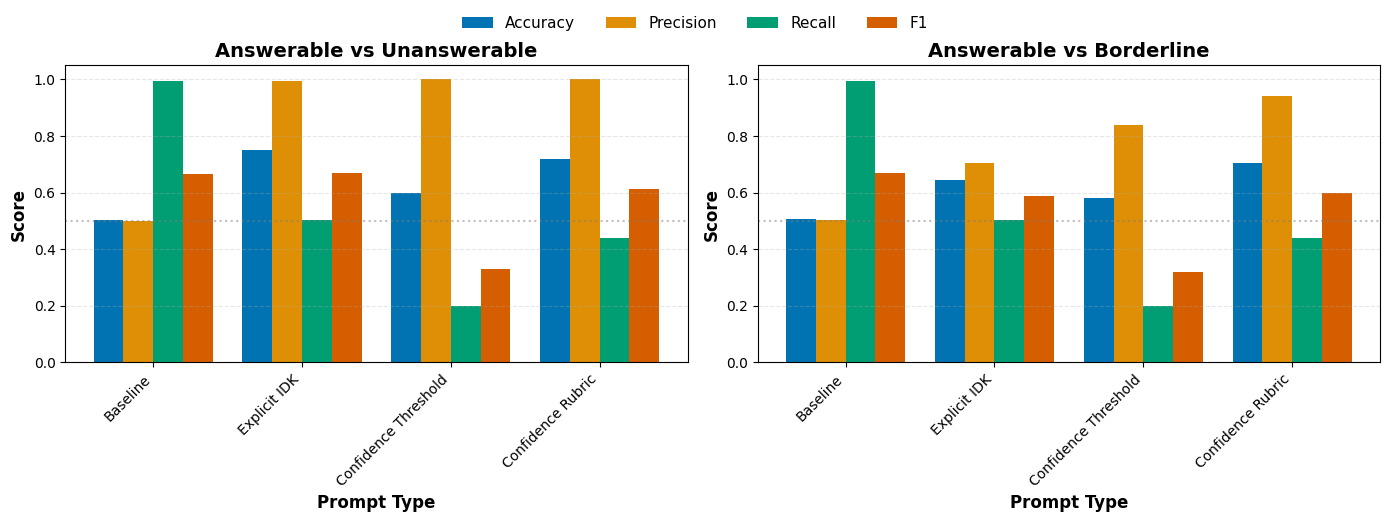

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_palette("colorblind")
colors = sns.color_palette("colorblind", 4)

data = {
    'Answerable vs Unanswerable': {
        'Baseline': {'Accuracy': 0.5020, 'Precision': 0.5010, 'Recall': 0.9940, 'F1': 0.6662},
        'Explicit IDK': {'Accuracy': 0.7500, 'Precision': 0.9960, 'Recall': 0.5020, 'F1': 0.6676},
        'Confidence Threshold': {'Accuracy': 0.5990, 'Precision': 1.0000, 'Recall': 0.1980, 'F1': 0.3306},
        'Confidence Rubric': {'Accuracy': 0.7200, 'Precision': 1.0000, 'Recall': 0.4400, 'F1': 0.6111},
    },
    'Answerable vs Borderline': {
        'Baseline': {'Accuracy': 0.5070, 'Precision': 0.5035, 'Recall': 0.9940, 'F1': 0.6685},
        'Explicit IDK': {'Accuracy': 0.6460, 'Precision': 0.7051, 'Recall': 0.5020, 'F1': 0.5864},
        'Confidence Threshold': {'Accuracy': 0.5800, 'Precision': 0.8390, 'Recall': 0.1980, 'F1': 0.3204},
        'Confidence Rubric': {'Accuracy': 0.7060, 'Precision': 0.9402, 'Recall': 0.4400, 'F1': 0.5995},
    }
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

prompts = ['Baseline', 'Explicit IDK', 'Confidence Threshold', 'Confidence Rubric']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
# colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for i, (scenario, scenario_data) in enumerate(data.items()):
    ax = axes[i]
    
    x = np.arange(len(prompts))
    width = 0.2
    
    for j, metric in enumerate(metrics):
        values = [scenario_data[prompt][metric] for prompt in prompts]
        ax.bar(x + j*width, values, width, label=metric, color=colors[j])
    
    ax.set_xlabel('Prompt Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title(scenario, fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(prompts, rotation=45, ha='right')
    # ax.legend(loc='upper left')
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
           ncol=4, frameon=False, fontsize=11)

plt.tight_layout()
plt.savefig('prompt_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
print("\nPrecision Drop (Unanswerable → Borderline):")
for prompt in prompts:
    prec_unans = data['Answerable vs Unanswerable'][prompt]['Precision']
    prec_border = data['Answerable vs Borderline'][prompt]['Precision']
    drop = prec_unans - prec_border
    print(f"  {prompt:25s}: {prec_unans:.2%} → {prec_border:.2%} (Δ {drop:.1%})")

print("\nWinner: Confidence Rubric")
print("  - Maintains 94% precision on borderline (only 6% drop)")


Precision Drop (Unanswerable → Borderline):
  Baseline                 : 50.10% → 50.35% (Δ -0.2%)
  Explicit IDK             : 99.60% → 70.51% (Δ 29.1%)
  Confidence Threshold     : 100.00% → 83.90% (Δ 16.1%)
  Confidence Rubric        : 100.00% → 94.02% (Δ 6.0%)

Winner: Confidence Rubric
  - Maintains 94% precision on borderline (only 6% drop)
